# General functioning

The algorithm is divided into two main parts:

1. data_preparation.py -> Selecting the gaps: cut temporal and spatial data of a given variable from a xcube data cube and if requested create artificial gaps.
2. gapfilling.py -> Fill in the gaps: estimate the values in these gaps by creating a model for each pixel.

Each time 'GapDataset(ds, ds_name, variable, dimensions, artificial_gaps, actual_matrix).get_data()' is executed, a new directory is created in 'application_results/'.
Inside this directory the class "GapDataset" creates the following datasets:
'cube.zarr' stores the sliced data with the corresponding values of the specified variable for each pixel.
'actual.zarr' stores the actual data array where the gaps need to be filled.
If artificial gaps should be created, the arrays with the artificial gaps are stored in 'GapImitation/' with different gap sizes in each array.
'extra_matrix_lcc.zarr' has extra data e.g. corresponding land cover class values for each value in the matrix. The extra matrix can be used as a predictor configuration for the gap filling process.

In the second step the execution of 'Gapfiller(ds_name, learning_function, hyperparameters, predictor).gapfill()' creates the subdirectory 'Results/'.
For each gap the values will be estimated. 
The average difference of the estimated value and the actual value (only available at artificial gaps) of each gap will be calculated as well as the mean absolute error based on cross validation. 
The filled arrays will be stored in 'Results/' subdirectory.


## Data

The currently used data is from the [xcube](https://xcube.readthedocs.io/en/latest/installation.html) dataset.
This gapfilling algorithms works currently for the EarthSystemDataCubeS3 but its functionality can be adapted for other gapfilling use cases and other data cubes.
For more information about the xcube data, follow the link.  

## Parameters

### GapDataset class

#### ds
- data cube (type: xarray.DataArray) with gaps e.g. a EarthSystemDataCubeS3

#### ds_name
- specify the name of the dataset -> a new directory with this name will be created in 'application_results/' - if a directory with this name already exists, it will be overwritten
- DEFAULT: 'Test123'
- other options: 
    - free choice - no restriction for the naming convention

#### variable
- variable that will be estimated. More possible variables from the Earth System Data Cube can be found [here](https://deepesdl.readthedocs.io/en/latest/datasets/ESDC/#variable-list)
- DEFAULT: 'land_surface_temperature'
- other options:
    - 'air_temperature_2m'

#### dimensions
- dimensions of the data cube that will be sliced e.g. lat, lon, times
- DEFAULT: dimensions = {'lat': (54, 48), 'lon': (6, 15), 'times': (datetime.date(2008, 11, 1), datetime.date(2008, 12, 31))}
- other options:
    - free choice - global range: lat = (90, -90), lon = (-180, 180), times: total range from 1979-2018, but most values are recorded from 2002-2011

#### artificial_gaps
- list of artificial gaps that can be created -> the gapfilling algorithm performs on artificial gaps if they are stated; if this parameter is None, it estimates real gaps in the matrix
- DEFAULT: None
- other options
    - free choice - total range for each element from 0-1, e.g. [0.001, 0.01, 0.1, 0.25, 0.5, 0.75]

#### actual_matrix
- specifies the date (datetime.date) of the original matrix where the gaps should be filled; if the date should be random, select 'Random'
- DEFAULT: 'Random'
- other options
    - free choice (datetime.date) 

### Gapfiller class

#### ds_name
- same as the name for the GapDataset class -> otherwise no directory will be found and the gapfilling algorithm cannot perform
- DEFAULT: 'Test123'
- other options: 
    - free choice - but it should have the name of an existing directory in 'application_results/'
 
#### learning_function
- select the learning function to train the model; currently just SupportVectorRegression possible -> will be updated soon
- DEFAULT: 'SVR'

#### hyperparameters
- strategies for configuring hyperparameters
- DEFAULT: 'RandomGridSearch' - random grid search
- other options:
    - 'FullGridSearch' - full grid search
    - 'Custom' - custom settings according to the scikit-learn syntax that can be changed in the 'learning_function'-method - current settings: **params = {'kernel': 'linear', 'gamma': 'scale', 'C': 1000, 'epsilon': 1}

#### predictor
- strategies for selecting predictors
- DEFAULT: 'RandomPoints' - randomly selected 100 points in the matrix - if less than 100 points with values in the metric, all non-gap values will be used as predictors; if less than 50 pixel have known values, interpolation is used to estimate the gaps
- other options:
    - 'AllPoints' - all known values -> runtime can be very big
    - 'LCC' - the 40 closest pixels from the same land cover class (e.g. mixed forest) as the gap will be used as predictors - if there are less than 40 pixels from the same land cover class, the strategy changes to 'RandomPoints'

## Observations and recommendations (so far)

In terms of runtime and accuracy, 'RandomGridSearch' works best for configuring hyperparameters and 'LCC' for selecting predictors; 'RandomPoints' or other categorical variables might be suitable options to estimate the gaps, depending on the use case.
Since a model is created for each gap pixel, the runtime increases linearly proportional to the number of gaps, while the accuracy deteriorates only slightly.
For the number of training samples, no more than 40-100 arrays need to be cut from the respective area - since the recordings in the data cube occur every 8 days and the runtime increases with the number of training samples, 1-2 years could be sufficient as a time period. 

## Example with added artificial gaps

In [1]:
import datetime
from xcube.core.store import new_data_store
from ml4xcube.gapfilling.gap_filling import Gapfiller
from ml4xcube.gapfilling.gap_dataset import GapDataset

In [2]:
# Directory name
ds_name = 'GermanyNB_artificial_gaps'
# Variable that will be estimated e.g. 'land_surface_temperature' or 'air_temperature_2m'
variable = 'land_surface_temperature'
# Dimension values of the datacube, e.g. Latitude and longitude and of the area and times.
# Global range: lat = (90, -90), lon = (-180, 180)
dimensions = {
    'lat': (54, 48),
    'lon': (6, 15),
    'times': (datetime.date(2008, 1, 1), datetime.date(2008, 12, 31))
}
# List of artificial gaps that will be created
# if no artificial gaps should be created, the gapfilling algorithms will perform on real gaps
# options: None or list of artificial gap sizes e.g. [0.001, 0.01, 0.1, 0.25, 0.5, 0.75]
artificial_gaps = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75]
# Speficy whether the actual matrix will be chosen random or is from a specific file.
# Options: 'Random' or datetime.date of the specific file e.g. datetime.date(2008, 12, 14)
actual_matrix = datetime.date(2008, 9, 1) 

# 2 ways for loading the data cube
# 1) open a local data cube: ds = xr.open_zarr("path/to/cube.zarr")[variable]
# 2) get the data cube from the store
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
# Select the variable of interest from the dataset
ds = dataset[variable]

In [3]:
# Get the data from the data cube
GapDataset(ds, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()

GermanyNB_artificial_gaps {'time': 46, 'lat': 72, 'lon': 108}
date: 2008-09-01
real gap size:  9 %
6 arrays with the following gaps were created: 1.0%, 5.0%, 10.0%, 25.0%, 50.0%, 75.0%
These arrays are saved in //home/julia/ML-Toolkits/application_results/GermanyNB_artificial_gaps/
runtime: 1.63


In [4]:
# Choose hyperparameter settings. Options: 'RandomGridSearch' | 'FullGridSearch' | 'Custom'
hyperparameters = "RandomGridSearch"
# Choose the predictor type. Options: 'AllPoints' | 'LCC' | 'RandomPoints'
predictor = "LCC"
# Choose learning function: Options (will be updated soon): 'SVR' for SupportVectorRegression
learning_function = "SVR"

In [5]:
# Perform the gap filling using the chosen settings
SVR_Gapfiller = Gapfiller(ds_name=ds_name, learning_function=learning_function, hyperparameters=hyperparameters, predictor=predictor).gapfill()

Fill the gaps of 6 array(s) with the following gap size: 1.0%, 5.0%, 10.0%, 25.0%, 50.0%, 75.0%
The array(s) are saved in: //home/julia/ML-Toolkits/application_results/GermanyNB_artificial_gaps/
Date: 2008-09-01 

gap size: 1.0 % -> 77 pixel 
training pictures: 45
100%|████████████████████| 78/78 [00:02<00:00, 36.33it/s]
MAE actual: 1.365
MAE cross validation: 1.11
runtime: 2.33 seconds 

gap size: 5.0 % -> 388 pixel 
training pictures: 45
100%|████████████████████| 389/389 [00:08<00:00, 45.48it/s]
MAE actual: 1.194
MAE cross validation: 1.047
runtime: 9.18 seconds 

gap size: 10.0 % -> 777 pixel 
training pictures: 45
100%|████████████████████| 778/778 [00:17<00:00, 43.83it/s]
MAE actual: 1.159
MAE cross validation: 1.078
runtime: 19.28 seconds 

gap size: 25.0 % -> 1944 pixel 
training pictures: 45
100%|████████████████████| 1944/1944 [00:43<00:00, 44.41it/s]
MAE actual: 1.218
MAE cross validation: 1.131
runtime: 47.48 seconds 

gap size: 50.0 % -> 3888 pixel 
training pictures: 45
1

## Example without artificial gaps where the algorithm estimates real gaps

In [6]:
# In this example we will use the same xcube array to estimate the real gaps of this example
# We just need to specify a different name to not override the results
ds_name = 'GermanyNB_with_real_gaps'
artificial_gaps = None

GapDataset(ds, ds_name, dimensions, artificial_gaps, actual_matrix).get_data()

GermanyNB_with_real_gaps {'time': 46, 'lat': 72, 'lon': 108}
date: 2008-09-01
real gap size:  9 %
runtime: 1.4


In [7]:
# Directory name based on the input name in 'GapDataset'
# We will use the same parameter as in the previous example
SVR_Gapfiller = Gapfiller(ds_name=ds_name, learning_function='SVR', hyperparameters=hyperparameters, predictor=predictor).gapfill()

Fill the gaps of 1 array(s) with the following gap size: 8.7%
The array(s) are saved in: //home/julia/ML-Toolkits/application_results/GermanyNB_with_real_gaps/
Date: 2008-09-01 

gap size: 8.7 % -> 676 pixel 
training pictures: 45
100%|████████████████████| 678/678 [00:13<00:00, 50.87it/s]
runtime: 13.34 seconds 

The missing values of the gaps are now filled. You can find the results in //home/julia/ML-Toolkits/application_results/GermanyNB_with_real_gaps/Results/


## Visualisation

In [8]:
import os
import numpy as np
import xarray as xr
from ml4xcube.xr_plots import plot_slice

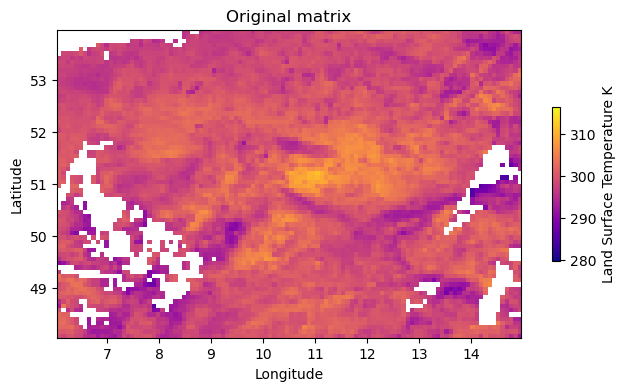

In [10]:

variable = 'land_surface_temperature'
directory = "../application_results/GermanyNB_artificial_gaps/"

xr_slice = xr.open_zarr(directory + "actual.zarr").compute()
masked_array = np.ma.masked_where(xr_slice[variable] == -100, xr_slice[variable])
xr_slice[variable] = (xr_slice[variable].dims, masked_array)

vmin = np.nanmin(masked_array) - 5
vmax = np.nanmax(masked_array) + 5

plot_slice(
    ds= xr_slice,
    var_to_plot = variable,  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Original matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      # use calculated vmin
    vmax        = vmax,      # use calculated vmax
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

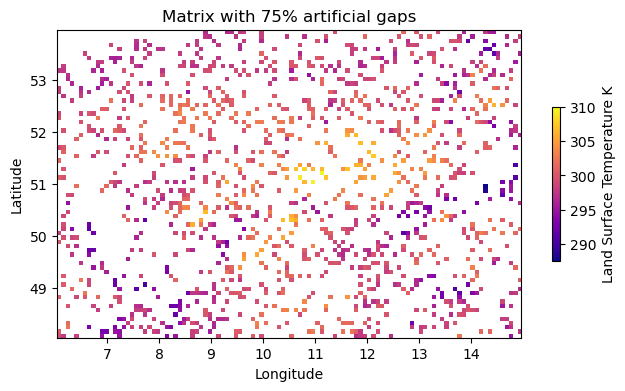

In [11]:
# Load the array with 75% imitated gaps
gap_size = '0.75'
xr_slice = xr.open_zarr(directory + "GapImitation/" + str(actual_matrix) + "_" + gap_size + ".zarr").compute()
masked_array = np.ma.masked_where(xr_slice[variable] == -100, xr_slice[variable])
xr_slice[variable] = (xr_slice[variable].dims, masked_array)

plot_slice(
    ds          = xr_slice,
    var_to_plot = variable,  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Matrix with 75% artificial gaps',
    label       = 'Land Surface Temperature K',
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

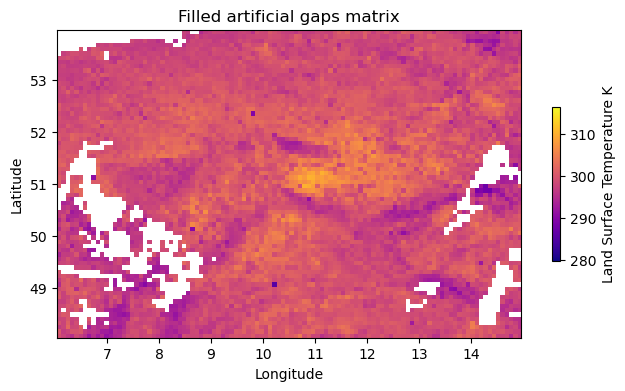

In [12]:
# Load the array with the filled artifical gaps
xr_slice = xr.open_zarr(directory + "Results/" + str(actual_matrix) + "-" + gap_size + ".zarr").compute()
masked_array = np.ma.masked_where(xr_slice["__xarray_dataarray_variable__"] == -100, xr_slice["__xarray_dataarray_variable__"])
xr_slice["__xarray_dataarray_variable__"] = (xr_slice["__xarray_dataarray_variable__"].dims, masked_array)

plot_slice(
    ds= xr_slice,
    var_to_plot = "__xarray_dataarray_variable__",  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Filled artificial gaps matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      
    vmax        = vmax,      
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

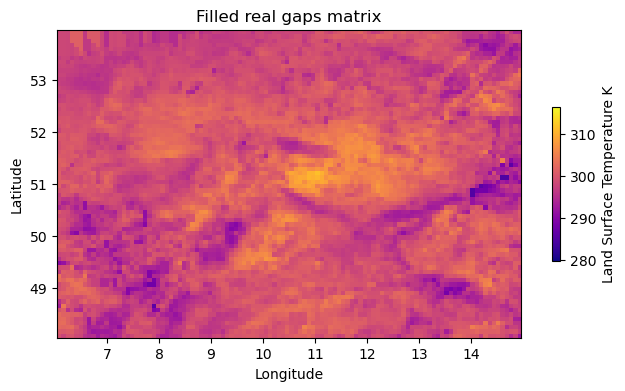

In [14]:
# Load the array with the filled artifical gaps
directory = "../application_results/GermanyNB_with_real_gaps/"

xr_slice = xr.open_zarr(directory + "Results/" + str(actual_matrix) + "-0.087.zarr").compute()
masked_array = np.ma.masked_where(xr_slice["__xarray_dataarray_variable__"] == -100, xr_slice["__xarray_dataarray_variable__"])
xr_slice["__xarray_dataarray_variable__"] = (xr_slice["__xarray_dataarray_variable__"].dims, masked_array)

plot_slice(
    ds= xr_slice,
    var_to_plot = "__xarray_dataarray_variable__",  # replace with your actual variable to plot
    color_map   = 'plasma',
    title       = 'Filled real gaps matrix',
    label       = 'Land Surface Temperature K',
    vmin        = vmin,      
    vmax        = vmax,      
    xdim        = 'lon',
    ydim        = 'lat',
    fig_size    = (8,4)
)

## Visualisation with Lexcube

To visualize the results in a cube you can also use the lexcube library. In this example we fill in the gaps of the same data cube as above for all January data and visualize the results afterwords.

In [14]:
import os
import lexcube
import numpy as np
import xarray as xr

In [15]:
variable = 'land_surface_temperature'
dimensions = {
    'lat': (54, 48),
    'lon': (6, 15),
    'times': (datetime.date(2008, 1, 1), datetime.date(2008, 12, 31))
}

data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
ds = dataset[variable]

In [16]:
for time_val in list(ds.time.values):
    # Convert numpy.datetime64 to datetime.date
    actual_matrix = time_val.astype('datetime64[D]').astype(datetime.date)
    # Check if the year is 2008 and the month is January
    if actual_matrix.year == 2008 and actual_matrix.month == 1:
        ds_name = 'GermanyNB_lexcube_' + str(actual_matrix)
        GapDataset(ds, ds_name, dimensions, artificial_gaps=None, actual_matrix=actual_matrix).get_data()
        Gapfiller(ds_name, 'SVR', 'RandomGridSearch', 'LCC').gapfill()

GermanyNB_lexcube_2008-01-05 {'time': 46, 'lat': 72, 'lon': 108}
date: 2008-01-05
real gap size:  43 %
runtime: 0.65
Fill the gaps of 1 array(s) with the following gap size: 42.8%
The array(s) are saved in: /application_results/GermanyNB_lexcube_2008-01-05/
Date: 2008-01-05 

gap size: 42.8 % -> 3328 pixel 
training pictures: 45
100%|████████████████████| 3332/3332 [02:41<00:00, 20.62it/s]
runtime: 161.60 seconds 

The missing values of the gaps are now filled. You can find the results in /application_results/GermanyNB_lexcube_2008-01-05/Results/
GermanyNB_lexcube_2008-01-13 {'time': 46, 'lat': 72, 'lon': 108}
date: 2008-01-13
real gap size:  56 %
runtime: 0.87
Fill the gaps of 1 array(s) with the following gap size: 55.9%
The array(s) are saved in: /application_results/GermanyNB_lexcube_2008-01-13/
Date: 2008-01-13 

gap size: 55.9 % -> 4346 pixel 
training pictures: 45
100%|████████████████████| 4349/4349 [03:15<00:00, 22.24it/s]
runtime: 195.56 seconds 

The missing values of the ga

In [18]:
directory = 'application_results/'
subdirectory = 'GermanyNB_lexcube'
cube_list = []
# Loop through the base directory
for root, dirs, files in os.walk(directory):
    for dir_name in dirs:
    # Check if the directory name starts with ..
        if dir_name.startswith(subdirectory):
            results_path = os.path.join(root, dir_name, "Results")
            # Find all zarr datasets in the "Results" subdirectory
            for file in os.listdir(results_path):
                matrix = xr.open_zarr(os.path.join(results_path, file))['__xarray_dataarray_variable__']
                cube_list.append(matrix)

# Sort the cube_list based on the time value of each DataArray
cube_list_sorted = sorted(cube_list, key=lambda data_array: data_array.time.values)
final_cube = xr.concat(cube_list_sorted, dim='time')

In [19]:
# Visualize the results with lexcube
l = lexcube.Cube3DWidget(final_cube, cmap="thermal_r")
l

Cube3DWidget(api_metadata={'/api': {'status': 'ok', 'api_version': 5}, '/api/datasets': [{'id': 'default', 'sh…